In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, QuantileTransformer
from sklearn.impute import SimpleImputer
import numpy as np

In [2]:
import sys
import os
from os.path import dirname
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
sys.path.append(dirname('../src'))
from src.utils import utils
data = pd.read_csv("../Data/hk_database_prueba.csv")
data.head(5)

,id,cx_curp,df_nacimiento,cs_sexo,first_cx,last_cx,count_cx_w,years_cx,window,x_start,...,I15,I159,I139,I131,I130,I11,I151,I158,I13,I132
0,#EHA6911199IMKERC1-1,#EHA6911199IMKERC1,19/11/1969,F,16/04/2018,06/10/2020,24.0,3,1,16/04/2018,...,0,0,0,0,0,0,0,0,0,0
1,#EHE671124ISYRCRC1-1,#EHE671124ISYRCRC1,24/11/1967,F,04/04/2017,11/12/2019,1.0,3,1,04/04/2017,...,0,0,0,0,0,0,0,0,0,0
2,AAAA2201010EDBBRC1-1,AAAA2201010EDBBRC1,16/06/1922,M,18/01/2005,10/10/2011,29.0,7,1,18/01/2005,...,0,0,0,0,0,0,0,0,0,0
3,AAAA2201010EDBBRC1-2,AAAA2201010EDBBRC1,16/06/1922,M,18/01/2005,10/10/2011,27.0,7,2,18/01/2006,...,0,0,0,0,0,0,0,0,0,0
4,AAAA2201010EDBBRC1-3,AAAA2201010EDBBRC1,16/06/1922,M,18/01/2005,10/10/2011,24.0,7,3,18/01/2007,...,0,0,0,0,0,0,0,0,0,0


In [7]:
data['first_cx']= pd.to_datetime(data['first_cx'])
data['last_cx']= pd.to_datetime(data['last_cx'])
data['df_nacimiento']= pd.to_datetime(data['df_nacimiento'])

data['edad'] = np.nan
for i in range(len(data['cx_curp'])): 
    if pd.isna(data['df_nacimiento'][i]):
        data['edad'][i] = np.nan        
    else: 
        data['edad'][i] = (int(data['first_cx'][i].year-data['df_nacimiento'][i].year)+\
                        int(data['last_cx'][i].year-data['df_nacimiento'][i].year))/2
        
data["edad_range"] = np.nan
data.loc[(data['edad'] <  11), 'edad_range'] = 1#'hasta 10 años'
data.loc[(data['edad'] > 10) & (data['edad'] <= 20), 'edad_range'] = 2#'11-20'
data.loc[(data['edad'] > 20) & (data['edad'] <= 30), 'edad_range'] = 3#'21-30'
data.loc[(data['edad'] > 30) & (data['edad'] <= 40), 'edad_range'] = 4#'31-40'
data.loc[(data['edad'] > 40) & (data['edad'] <= 50), 'edad_range'] = 5#'41-50'
data.loc[(data['edad'] > 50) & (data['edad'] <= 60), 'edad_range'] = 6#'51-60'
data.loc[(data['edad'] > 60) & (data['edad'] <= 70), 'edad_range'] = 7#'61-70'
data.loc[(data['edad'] > 70) & (data['edad'] <= 80), 'edad_range'] = 8#'71-80'
data.loc[(data['edad'] > 80) & (data['edad'] <= 90), 'edad_range'] = 9#'81-90'
data.loc[(data['edad'] > 90  ), 'edad_range'] = 10#'91 y más'

data["imc_calculado"] = np.nan
data["imc_calculado"] = np.where(~pd.isna(data["fn_peso_median"])&~pd.isna(data["fn_talla_median"]), \
                                       (data["fn_peso_median"]/(data["fn_talla_median"]**2)), 
                                       np.nan)
data["imc_range"] = np.nan
data.loc[(data['imc_calculado'] <  18.5), 'imc_range'] = 1#'Bajo peso'
data.loc[(data['imc_calculado'] >= 18.5) & (data['imc_calculado'] < 25), 'imc_range'] = 2#'Peso normal'
data.loc[(data['imc_calculado'] >= 25  ) & (data['imc_calculado'] < 30), 'imc_range'] = 3#'Sobrepeso'
data.loc[(data['imc_calculado'] >= 30  ), 'imc_range'] = 4#'Obesidad'

In [8]:
data = data.drop(['id','cx_curp','df_nacimiento','cs_sexo','first_cx','last_cx','x_start','x_end','y_start','y_end',
         'I10X','I119','I129','I110','I150','I120','I12','I15','I159','I139','I131','I130','I11','I151',
         'I158','I13','I132','edad','imc_calculado','anio_dx','fn_peri_cefalico_mean',
 'fn_peri_cefalico_median',
 'fn_peri_cefalico_max',
 'fn_peri_cefalico_min',
 'fn_peri_cefalico_std',
 'fn_peri_toracico_mean',
 'fn_peri_toracico_median',
 'fn_peri_toracico_max',
 'fn_peri_toracico_min',
 'fn_peri_toracico_std',
 'fn_peri_abdominal_mean',
 'fn_peri_abdominal_median',
 'fn_peri_abdominal_max',
 'fn_peri_abdominal_min',
 'fn_peri_abdominal_std',
 'fn_pvc_mean',
 'fn_pvc_median',
 'fn_pvc_max',
 'fn_pvc_min',
 'fn_pvc_std',
 'fn_temp_incubadora_mean',
 'fn_temp_incubadora_median',
 'fn_temp_incubadora_max',
 'fn_temp_incubadora_min',
 'fn_temp_incubadora_std'], axis=1)

In [9]:
data.rename(columns = {'Tirotoxicosis [hipertiroidismo]':'Tirotoxicosis_hipertiroidismo', 
                     'Deficiencia de niacina [pelagra]':'Deficiencia de niacina_pelagra'}, inplace = True)

In [11]:
X = data.loc[:, data.columns != 'label']
print(X.shape)
Y = data[["label"]]
print(Y.shape)

(3997, 348)
(3997, 1)


<AxesSubplot:>

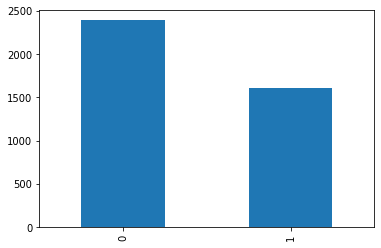

In [12]:
data['label'].value_counts().plot.bar()

In [13]:
data.shape

(3997, 349)

In [20]:
col = list(data.columns)
col

['count_cx_w',
 'years_cx',
 'window',
 'Diabetes mellitus tipo 2',
 'label',
 'Enfermedades del sistema circulatorio',
 'Enfermedades endocrinas nutricionales y metabolicas',
 'Enfermedades del sistema osteomuscular y del tejido conjuntivo',
 'Enfermedades del sistema nervioso',
 'Factores que influyen en el estado de salud y contacto con los servicios de salud',
 'Enfermedades del sistema genitourinario',
 'Enfermedades del sistema respiratorio',
 'Enfermedades del ojo y sus anexos',
 'Trastornos mentales y del comportamiento',
 'Enfermedades del sistema digestivo',
 'Sintomas signos y hallazgos anormales clinicos y de laboratorio no clasificados en otra parte',
 'Enfermedades de oido y de la apofisis mastoides',
 'Ciertas enfermedades infecciosas y parasitarias',
 'Enfermedades de la piel y del tejido subcutaneo',
 'Traumatismos envenenamientos y algunas otras consecuencias de causas externas',
 'Tumores (neoplasias)',
 'Malformaciones congenitas deformidades y anomalias cromosomica

### Imputaciones

In [21]:
# Imputatio
my_imputer = SimpleImputer()
d_inp = pd.DataFrame(my_imputer.fit_transform(data))
d_inp

,0,1,2,3,4,5,6,7,8,9,...,339,340,341,342,343,344,345,346,347,348
0,24.0,3.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,32.675,0.000000,0.000000,29.475,0.000000,0.000000,30.0,0.000000,5.0,3.0
1,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,32.675,0.030956,0.465554,29.475,0.015781,0.018209,30.0,0.000607,6.0,3.0
2,29.0,7.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,32.675,0.000000,0.000000,29.475,0.000000,0.000000,30.0,0.000000,9.0,4.0
3,27.0,7.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,32.675,0.000000,0.000000,29.475,0.000000,0.000000,30.0,0.000000,9.0,4.0
4,24.0,7.0,3.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,32.675,0.000000,0.000000,29.475,0.000000,0.000000,30.0,0.000000,9.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3992,8.0,15.0,11.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,32.675,0.030956,0.465554,29.475,0.015781,0.018209,30.0,0.000607,6.0,3.0
3993,5.0,15.0,12.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,32.675,0.000000,0.000000,29.475,0.000000,0.000000,30.0,0.000000,6.0,3.0
3994,5.0,15.0,13.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,32.675,0.000000,0.000000,29.475,0.000000,0.000000,30.0,0.000000,6.0,3.0
3995,17.0,4.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,32.675,0.000000,0.000000,29.475,0.000000,0.000000,30.0,0.000000,6.0,4.0


In [22]:
d_inp.shape

(3997, 349)

In [24]:
d_inp.columns = col
d_inp

,count_cx_w,years_cx,window,Diabetes mellitus tipo 2,label,Enfermedades del sistema circulatorio,Enfermedades endocrinas nutricionales y metabolicas,Enfermedades del sistema osteomuscular y del tejido conjuntivo,Enfermedades del sistema nervioso,Factores que influyen en el estado de salud y contacto con los servicios de salud,...,FARMACOS_UTILIZADOS_EN_CÁNCER_DE_MAMA_mean,FARMACOS_UTILIZADOS_EN_CÁNCER_DE_MAMA_count,FARMACOS_UTILIZADOS_EN_OSTEOPOROSIS_sum,FARMACOS_UTILIZADOS_EN_OSTEOPOROSIS_mean,FARMACOS_UTILIZADOS_EN_OSTEOPOROSIS_count,ANTIARRITMICOS_sum,ANTIARRITMICOS_mean,ANTIARRITMICOS_count,edad_range,imc_range
0,24.0,3.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,32.675,0.000000,0.000000,29.475,0.000000,0.000000,30.0,0.000000,5.0,3.0
1,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,32.675,0.030956,0.465554,29.475,0.015781,0.018209,30.0,0.000607,6.0,3.0
2,29.0,7.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,32.675,0.000000,0.000000,29.475,0.000000,0.000000,30.0,0.000000,9.0,4.0
3,27.0,7.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,32.675,0.000000,0.000000,29.475,0.000000,0.000000,30.0,0.000000,9.0,4.0
4,24.0,7.0,3.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,32.675,0.000000,0.000000,29.475,0.000000,0.000000,30.0,0.000000,9.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3992,8.0,15.0,11.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,32.675,0.030956,0.465554,29.475,0.015781,0.018209,30.0,0.000607,6.0,3.0
3993,5.0,15.0,12.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,32.675,0.000000,0.000000,29.475,0.000000,0.000000,30.0,0.000000,6.0,3.0
3994,5.0,15.0,13.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,32.675,0.000000,0.000000,29.475,0.000000,0.000000,30.0,0.000000,6.0,3.0
3995,17.0,4.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,32.675,0.000000,0.000000,29.475,0.000000,0.000000,30.0,0.000000,6.0,4.0


In [26]:
X = d_inp.loc[:, d_inp.columns != 'label']
Y = d_inp[["label"]]

In [27]:
print(X.shape)
print(Y.shape)

(3997, 348)
(3997, 1)


In [28]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=4)

In [29]:
# Parámetros para la mejor selección de variables
grid_param = {
    'n_estimators': [100, 150],
    'min_samples_split': [2, 5, 7, 10,15]
}

#classifier = RandomForestClassifier()
classifier = RandomForestClassifier(oob_score=True, random_state=1234)

#Prepareción del GridSearch
gd_sr = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     scoring='precision',
                     cv=2)

In [30]:
#Fit del grid search con r
gd_sr.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=RandomForestClassifier(oob_score=True,
                                              random_state=1234),
             param_grid={'min_samples_split': [2, 5, 7, 10, 15],
                         'n_estimators': [100, 150]},
             scoring='precision')

In [31]:
# mejor configuración 
gd_sr.best_estimator_

RandomForestClassifier(n_estimators=150, oob_score=True, random_state=1234)

In [32]:
gd_sr.best_estimator_.n_features_

348

In [33]:
gd_sr.best_estimator_.oob_score_

0.9588845191276367

### Importancia de variables

In [34]:
best_rf = gd_sr.best_estimator_
best_rf.feature_importances_

array([3.42430098e-02, 5.77932692e-03, 4.81802314e-03, 7.73955076e-03,
       1.32419104e-01, 1.10251443e-02, 1.66160423e-03, 1.01836492e-03,
       1.65745657e-03, 1.39158161e-03, 2.11696730e-03, 1.58137448e-03,
       1.82536176e-03, 1.77089052e-03, 1.56942005e-03, 1.02122768e-03,
       2.05816509e-03, 1.33280232e-03, 1.36291676e-03, 9.32673635e-04,
       4.19081975e-04, 5.61127997e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.41262690e-04, 2.43080191e-04, 3.46308411e-04,
       4.89943673e-05, 4.93298442e-04, 5.03557491e-03, 1.60493400e-04,
       2.47419429e-03, 3.08484553e-04, 6.31732077e-05, 1.77301385e-04,
       5.49655260e-05, 2.60837201e-04, 1.59265108e-04, 2.24487134e-04,
       9.86221693e-05, 2.26396187e-04, 0.00000000e+00, 2.72252762e-05,
       6.62066624e-04, 3.42079048e-04, 1.01705109e-04, 0.00000000e+00,
       1.01711579e-04, 3.19679321e-05, 4.65152764e-05, 6.57906188e-06,
       0.00000000e+00, 6.87879950e-04, 3.21397554e-05, 0.00000000e+00,
      

In [35]:
feature_importance = pd.DataFrame({'importance': best_rf.feature_importances_,
                                  'feature': X.columns.values})

In [36]:
importancias = feature_importance.sort_values(by="importance", ascending=False)

In [37]:
pd.set_option('display.max_rows', importancias.shape[0]+1)
importancias

,importance,feature
4,0.132419,Enfermedades del sistema circulatorio
240,0.066108,ANTIHIPERTENSIVOS_count
238,0.054137,ANTIHIPERTENSIVOS_sum
346,0.048421,edad_range
198,0.036704,fn_ta_sistolica_max
0,0.034243,count_cx_w
206,0.033448,fn_ta_diastolica_count
200,0.031896,fn_ta_sistolica_count
239,0.029535,ANTIHIPERTENSIVOS_mean
196,0.027766,fn_ta_sistolica_mean


In [38]:
col_imp = list(importancias[importancias['importance']>0]['feature'])
col_imp.append('label')
col_imp

['Enfermedades del sistema circulatorio',
 'ANTIHIPERTENSIVOS_count',
 'ANTIHIPERTENSIVOS_sum',
 'edad_range',
 'fn_ta_sistolica_max',
 'count_cx_w',
 'fn_ta_diastolica_count',
 'fn_ta_sistolica_count',
 'ANTIHIPERTENSIVOS_mean',
 'fn_ta_sistolica_mean',
 'fn_talla_count',
 'fn_peso_count',
 'fn_ta_diastolica_max',
 'Diabetes mellitus tipo 2 sin mención de complicación',
 'ANTIULCEROSOS_Y_PROTECTORES_DE_LA_MUCOSA_GÁSTRICA_count',
 'ANTIULCEROSOS_Y_PROTECTORES_DE_LA_MUCOSA_GÁSTRICA_sum',
 'Enfermedades endocrinas nutricionales y metabolicas',
 'Trastornos del metabolismo de las lipoproteínas y otras lipidemias',
 'fn_temperatura_count',
 'ANTIDIABÉTICOS_sum',
 'ANTIDIABÉTICOS_mean',
 'fn_ta_diastolica_mean',
 'Diabetes mellitus tipo 2',
 'ANTIINFLAMATORIOS_NO_ESTEROIDEOS_count',
 'ANTIINFLAMATORIOS_NO_ESTEROIDEOS_sum',
 'in_frec_cardiaca_count',
 'fn_ta_sistolica_median',
 'ANTIDIABÉTICOS_count',
 'VITAMÍNICOS_count',
 'fn_temperatura_max',
 'in_frec_respiratoria_count',
 'years_cx',
 '

In [39]:
d_fe_f = pd.concat([X, Y])

In [40]:
d_fe_f = d_fe_f[col_imp]
d_fe_f

,Enfermedades del sistema circulatorio,ANTIHIPERTENSIVOS_count,ANTIHIPERTENSIVOS_sum,edad_range,fn_ta_sistolica_max,count_cx_w,fn_ta_diastolica_count,fn_ta_sistolica_count,ANTIHIPERTENSIVOS_mean,fn_ta_sistolica_mean,...,FARMACOS_UTILIZADOS_EN_OSTEOPOROSIS_mean,Trastornos no reumáticos de la válvula aórtica,Hipertensión secundaria,Trastornos endocrinos y metabólicos consecutivos a procedimientos no clasificados en otra parte,Tiroiditis,Enfermedad cardiorrenal hipertensiva,Otros trastornos metabólicos,FARMACOS_UTILIZADOS_EN_CÁNCER_DE_MAMA_mean,Enfermedades valvulares múltiples,label
0,0.0,0.000000,0.000000,5.0,120.0,24.0,21.0,21.0,49.106561,112.4,...,29.475,0.0,0.0,0.0,0.0,0.0,0.0,32.675,0.0,NaN
1,0.0,4.731108,238.402822,6.0,110.0,1.0,1.0,1.0,49.106561,110.0,...,29.475,0.0,0.0,0.0,0.0,0.0,0.0,32.675,0.0,NaN
2,1.0,18.000000,1920.000000,9.0,160.0,29.0,11.0,12.0,106.700000,131.2,...,29.475,0.0,0.0,0.0,0.0,0.0,0.0,32.675,0.0,NaN
3,1.0,10.000000,1050.000000,9.0,150.0,27.0,5.0,6.0,105.000000,140.0,...,29.475,0.0,0.0,0.0,0.0,0.0,0.0,32.675,0.0,NaN
4,1.0,8.000000,270.000000,9.0,145.0,24.0,4.0,4.0,33.800000,136.2,...,29.475,0.0,0.0,0.0,0.0,0.0,0.0,32.675,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [41]:
# Guardando modelo
import pickle
pickle.dump(gd_sr, open("modelo_ing.pkl", "wb"))

In [42]:
# Guardando Feature Selection
utils.save_df(d_fe_f, "../Data/feature_sel.pkl")

### Importancia de variables usando shap

In [43]:
import xgboost
import shap

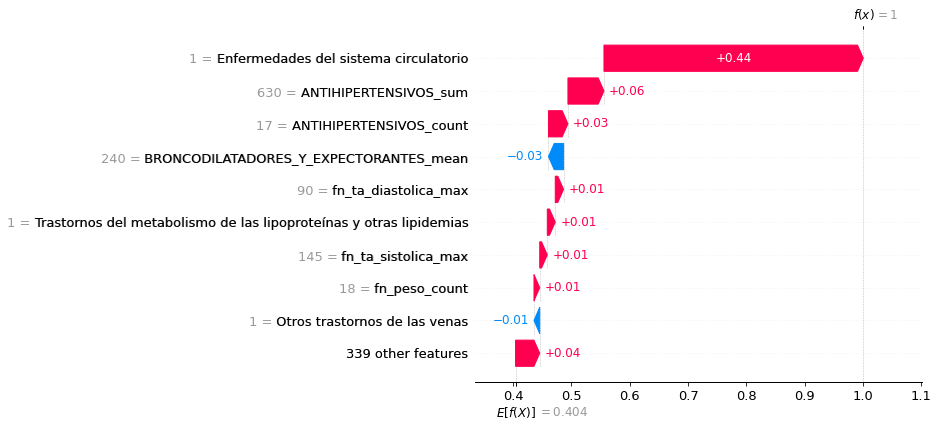

In [44]:
# train an XGBoost model
#X, y = shap.datasets.boston()
model = xgboost.XGBRegressor().fit(X_train, y_train)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

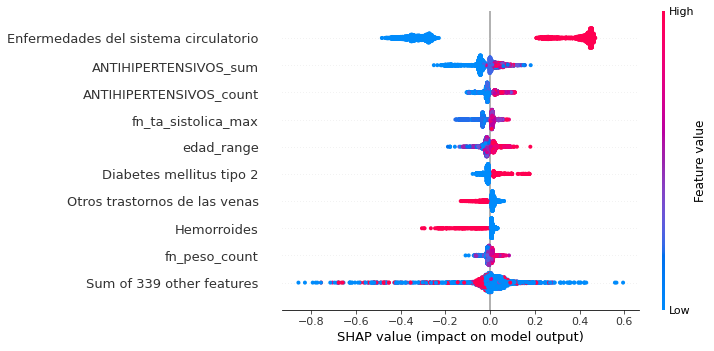

In [45]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

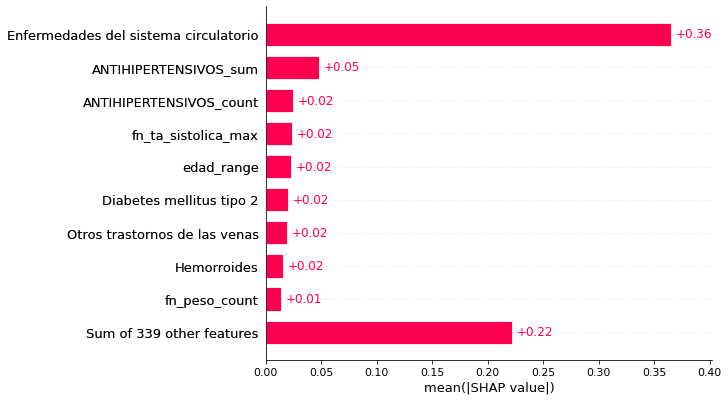

In [46]:
shap.plots.bar(shap_values)